In [ ]:
from IPython.display import HTML, display

def set_css():
    display(HTML('''
    <style>
        pre {
            white-space: pre-wrap;
        }
    </style>
    '''))

get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
from huggingface_hub import interpreter_login
interpreter_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): ··········
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
%%capture
!pip install datasets

In [ ]:
from datasets import load_dataset, load_from_disk
import pandas as pd

ds = load_dataset("nbertagnolli/counsel-chat", split="train")

Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/2775 [00:00<?, ? examples/s]

In [ ]:
df = ds.to_pandas()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2775 entries, 0 to 2774
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   questionID     2775 non-null   int64 
 1   questionTitle  2775 non-null   object
 2   questionText   2636 non-null   object
 3   questionLink   2775 non-null   object
 4   topic          2775 non-null   object
 5   therapistInfo  2775 non-null   object
 6   therapistURL   2775 non-null   object
 7   answerText     2749 non-null   object
 8   upvotes        2775 non-null   int64 
 9   views          2775 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 216.9+ KB


In [ ]:
df.head()

,questionID,questionTitle,questionText,questionLink,topic,therapistInfo,therapistURL,answerText,upvotes,views
0,0,Do I have too many issues for counseling?,I have so many issues to address. I have a his...,https://counselchat.com/questions/do-i-have-to...,depression,Jennifer MolinariHypnotherapist & Licensed Cou...,https://counselchat.com/therapists/jennifer-mo...,It is very common for people to have multiple ...,3,1971
1,0,Do I have too many issues for counseling?,I have so many issues to address. I have a his...,https://counselchat.com/questions/do-i-have-to...,depression,"Jason Lynch, MS, LMHC, LCAC, ADSIndividual & C...",https://counselchat.com/therapists/jason-lynch...,"I've never heard of someone having ""too many i...",2,386
2,0,Do I have too many issues for counseling?,I have so many issues to address. I have a his...,https://counselchat.com/questions/do-i-have-to...,depression,Shakeeta TorresFaith Based Mental Health Couns...,https://counselchat.com/therapists/shakeeta-to...,Absolutely not. I strongly recommending worki...,2,3071
3,0,Do I have too many issues for counseling?,I have so many issues to address. I have a his...,https://counselchat.com/questions/do-i-have-to...,depression,"Noorayne ChevalierMA, RP, CCC, CCAC, LLP (Mich...",https://counselchat.com/therapists/noorayne-ch...,Let me start by saying there are never too man...,2,2643
4,0,Do I have too many issues for counseling?,I have so many issues to address. I have a his...,https://counselchat.com/questions/do-i-have-to...,depression,"Toni Teixeira, LCSWYour road to healing begins...",https://counselchat.com/therapists/toni-teixei...,I just want to acknowledge you for the courage...,1,256


In [ ]:
import re

df = df.dropna(subset=['questionText', 'answerText'])

def format_row(row, question_col, answer_col, therapist_info_col, therapist_url_col):
    question = row[question_col]
    answer = row[answer_col]
    therapist_info = row[therapist_info_col]
    therapist_url = row[therapist_url_col]

    if therapist_info:
        for name in therapist_info.split(', '):
            answer = answer.replace(name, '')

    if therapist_url in answer:
        answer = answer.replace(therapist_url, "").strip()
    answer = re.sub(r'\bhttps?:\/\/\S+\b', '', answer)

    question = ' '.join(question.split())
    answer = ' '.join(answer.split())

    return [
        {"from": "human", "value": question},
        {"from": "gpt", "value": answer}
    ]

df.loc[:, 'conversations'] = df.apply(lambda row: format_row(row, 'questionText', 'answerText', 'therapistInfo', 'therapistURL'), axis=1)

transformed_df = df[['conversations']]
transformed_df.to_json('transformed_data.jsonl', orient='records', lines=True)

print(transformed_df['conversations'][1])

[{'from': 'human', 'value': 'I have so many issues to address. I have a history of sexual abuse, I’m a breast cancer survivor and I am a lifetime insomniac. I have a long history of depression and I’m beginning to have anxiety. I have low self esteem but I’ve been happily married for almost 35 years. I’ve never had counseling about any of this. Do I have too many issues to address in counseling?'}, {'from': 'gpt', 'value': 'I\'ve never heard of someone having "too many issues" for therapy to be effective. A competent therapist will assist you in identifying the root causes of your problems and treat those first. If the underlying issues are addressed, your various symptoms should improve. For example, a history of sexual trauma can cause sleep disturbances, depression, anxiety, and low self-worth. I would start by addressing the underlying trauma using EMDR Therapy. EMDR allows the client to process unresolved trauma and to address negative core beliefs that develop in response to the 

In [ ]:
ds2 = load_dataset("thu-coai/esconv", split="train")
df2 = ds2.to_pandas()

Generating train split:   0%|          | 0/910 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/195 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/195 [00:00<?, ? examples/s]

In [ ]:
df2.head()

,text
0,"{""experience_type"": ""Current Experience"", ""emo..."
1,"{""experience_type"": ""Current Experience"", ""emo..."
2,"{""experience_type"": ""Current Experience"", ""emo..."
3,"{""experience_type"": ""Current Experience"", ""emo..."
4,"{""experience_type"": ""Previous Experience"", ""em..."


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    910 non-null    object
dtypes: object(1)
memory usage: 7.2+ KB


In [ ]:
import json
def convert_dialog(dialog):
    new_dialog = []
    for entry in dialog:
        new_entry = {
            "from": "human" if entry["speaker"] == "usr" else "gpt",
            "value": entry["text"]
        }
        new_dialog.append(new_entry)
    return new_dialog

def convert_row(row):
    data = json.loads(row)
    return convert_dialog(data["dialog"])

In [ ]:
df2['conversations'] = df2.iloc[:, 0].apply(convert_row)

In [ ]:
transformed_df2 = df2[["conversations"]]
transformed_df2.to_json("transformed_data2.jsonl", orient="records", lines=True)

In [ ]:
transformed_df2.head()

,conversations
0,"[{'from': 'human', 'value': 'Hello good aftern..."
1,"[{'from': 'gpt', 'value': 'How are you doing t..."
2,"[{'from': 'gpt', 'value': 'I feel obligated to..."
3,"[{'from': 'gpt', 'value': 'Hello! Hope you are..."
4,"[{'from': 'human', 'value': 'Hi can you help m..."


In [ ]:
transformed_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   conversations  910 non-null    object
dtypes: object(1)
memory usage: 7.2+ KB


In [ ]:
file_path = '/content/pair_data.csv'
ds3 = pd.read_csv(file_path)

data = {
    'questions': [],
    'answers': []
}

for index, row in ds3.iterrows():
    if pd.notnull(row['hq1']):
        data['questions'].append(row['prompt'])
        data['answers'].append(row['hq1'])
    if pd.notnull(row['hq2']):
        data['questions'].append(row['prompt'])
        data['answers'].append(row['hq2'])

df3 = pd.DataFrame(data)




In [ ]:
df3.head()

,questions,answers
0,"I know I am too big, and I probably should exe...",You are starting to think it’s time to do some...
1,"I know I am too big, and I probably should exe...",You have put a lot of effort into losing weigh...
2,I don’t trust doctors. I don’t trust the CDC....,You feel that your immune systems is strong en...
3,I don’t trust doctors. I don’t trust the CDC....,Putting your trust in others is hard for you. ...
4,"Doctor x, I don’t want the Covid vaccine for m...",You are worried about long term effects from t...


In [ ]:
print(df3)

                                             questions  \
0    I know I am too big, and I probably should exe...   
1    I know I am too big, and I probably should exe...   
2    I don’t trust doctors.  I don’t trust the CDC....   
3    I don’t trust doctors.  I don’t trust the CDC....   
4    Doctor x, I don’t want the Covid vaccine for m...   
..                                                 ...   
631               I can do that when I’m at the store.   
632  I’d like to eat less processed foods, but I gu...   
633  I’d like to eat less processed foods, but I gu...   
634  I like going to the gym, I like exercising; I ...   
635  I like going to the gym, I like exercising; I ...   

                                               answers  
0    You are starting to think it’s time to do some...  
1    You have put a lot of effort into losing weigh...  
2    You feel that your immune systems is strong en...  
3    Putting your trust in others is hard for you. ...  
4    You are worri

In [ ]:
df3.head()

,questions,answers
0,"I know I am too big, and I probably should exe...",You are starting to think it’s time to do some...
1,"I know I am too big, and I probably should exe...",You have put a lot of effort into losing weigh...
2,I don’t trust doctors. I don’t trust the CDC....,You feel that your immune systems is strong en...
3,I don’t trust doctors. I don’t trust the CDC....,Putting your trust in others is hard for you. ...
4,"Doctor x, I don’t want the Covid vaccine for m...",You are worried about long term effects from t...


In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636 entries, 0 to 635
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   questions  636 non-null    object
 1   answers    636 non-null    object
dtypes: object(2)
memory usage: 10.1+ KB


In [ ]:
def clean_text(text):
    text = re.sub(r'\.{3,}', ' ', text)
    text = ' '.join(text.split())
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9,\'\s]', '', text)
    return text

def transform_row(row):
    question = clean_text(row["questions"])
    answer = clean_text(row["answers"])
    return [
        {"from": "human", "value": question},
        {"from": "gpt", "value": answer}
    ]

df3['conversations'] = df3.apply(transform_row, axis=1)
transformed_df3 = df3[['conversations']]

transformed_df3.to_json('transformed_data3.jsonl', orient='records', lines=True)

print(transformed_df3['conversations'][1])


[{'from': 'human', 'value': 'I know I am too big, and I probably should exercise more and eat better, but I am so busy Ive got school, homework, and my job at the mall, so I dont see anywhere to fit it in Plus, I cant afford any of those gyms And none of my friends want to exercise with me Theyre lazier than I am'}, {'from': 'gpt', 'value': 'You have put a lot of effort into losing weight but it has not paid off You are starting to feel a bit desperate Diets dont seem to work for you You are looking for something different that might last'}]


In [ ]:
transformed_df3.head()

,conversations
0,"[{'from': 'human', 'value': 'I know I am too b..."
1,"[{'from': 'human', 'value': 'I know I am too b..."
2,"[{'from': 'human', 'value': 'I dont trust doct..."
3,"[{'from': 'human', 'value': 'I dont trust doct..."
4,"[{'from': 'human', 'value': 'Doctor x, I dont ..."


In [ ]:
ds4 = load_dataset("Amod/mental_health_counseling_conversations", split="train")
df4 = ds4.to_pandas()

Generating train split:   0%|          | 0/3512 [00:00<?, ? examples/s]

In [ ]:
def transform_row(row):
    question = clean_text(row["Context"])
    answer = clean_text(row["Response"])
    return [
        {"from": "human", "value": question},
        {"from": "gpt", "value": answer}
    ]

def clean_text(text):
    text = text.replace('\xa0', ' ')
    text = text.replace('\\', '')
    text = text.replace('/', '')
    text = re.sub(r'\.{3,}', ' ', text)
    text = ' '.join(text.split())
    text = re.sub(r'http\S+', '', text)
    re.sub(r'[^a-zA-Z0-9\s]', '', text)

    return text

df4['conversations'] = df4.apply(transform_row, axis=1)
transformed_df4 = df2[['conversations']]
transformed_df4.to_json('transformed_data4.json', orient='records', lines=True)

print(transformed_df4['conversations'][1])

[{'from': 'gpt', 'value': 'How are you doing today?'}, {'from': 'human', 'value': 'hello I am ok how are you?'}, {'from': 'gpt', 'value': "I am well, what's on your mind?"}, {'from': 'human', 'value': 'well as I stated above my father passed last year and now due to finances we need to move. I am out of work due to Covid19 it is hard moving not being able to support my family'}, {'from': 'gpt', 'value': 'So sorry to hear about your plight. Life is a roller coaster and sometimes it gets out of control, I hope things slow down so you can get things straightened out.'}, {'from': 'human', 'value': 'thank you! I find myself so stressed then I get scared and depressed wondering what will the future hold will we be ok will we take another hit will I get sick will my Mother be ok'}, {'from': 'gpt', 'value': 'I understand your concerns about being stressed, scared and depressed. The risk of family getting sick is certainly valid.'}, {'from': 'human', 'value': 'it keeps me up at night and I cant

In [ ]:
transformed_df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 910 entries, 0 to 909
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   conversations  910 non-null    object
dtypes: object(1)
memory usage: 7.2+ KB


In [ ]:
transformed_df4.head()

,conversations
0,"[{'from': 'human', 'value': 'Hello good aftern..."
1,"[{'from': 'gpt', 'value': 'How are you doing t..."
2,"[{'from': 'gpt', 'value': 'I feel obligated to..."
3,"[{'from': 'gpt', 'value': 'Hello! Hope you are..."
4,"[{'from': 'human', 'value': 'Hi can you help m..."


In [ ]:
## Do not merge the dataset without checking the structure
# transformed_merged = pd.concat([transformed_df, transformed_df2, transformed_df3], ignore_index=True)
# transformed_merged.head(1)

## Use ds4 for training (for now) as it's a same as nbertagnolli/counsel-chat

                                       conversations
0  [{'from': 'human', 'value': 'I have so many is...


In [ ]:
# transformed_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4158 entries, 0 to 4157
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   conversations  4158 non-null   object
dtypes: object(1)
memory usage: 32.6+ KB


In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(transformed_df4, test_size=0.1, random_state=42)
train_data.to_json("formatted_train_data.jsonl", orient="records", lines=True)
test_data.to_json("formatted_test_data.jsonl", orient="records", lines=True)

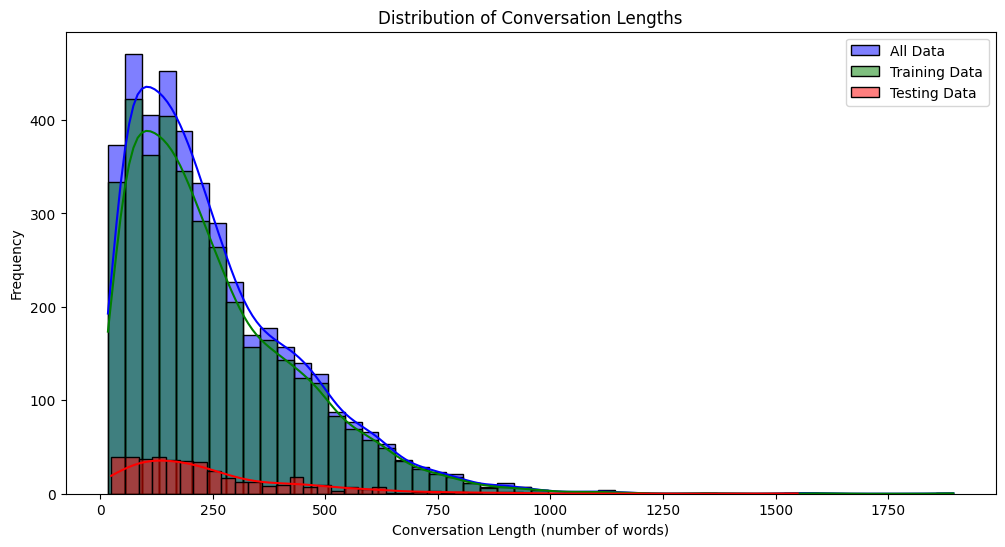

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def get_conversation_length(conversation):
    return sum(len(msg["value"].split()) for msg in conversation)

transformed_merged['length'] = transformed_merged['conversations'].apply(get_conversation_length)
train_data['length'] = train_data['conversations'].apply(get_conversation_length)
test_data['length'] = test_data['conversations'].apply(get_conversation_length)

plt.figure(figsize=(12, 6))
sns.histplot(transformed_merged['length'], kde=True, bins=50, color='blue', label='All Data')
sns.histplot(train_data['length'], kde=True, bins=50, color='green', label='Training Data')
sns.histplot(test_data['length'], kde=True, bins=50, color='red', label='Testing Data')
plt.legend()
plt.title('Distribution of Conversation Lengths')
plt.xlabel('Conversation Length (number of words)')
plt.ylabel('Frequency')
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-32-a926008b56c3>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Word', data=common_words_df, palette='viridis')


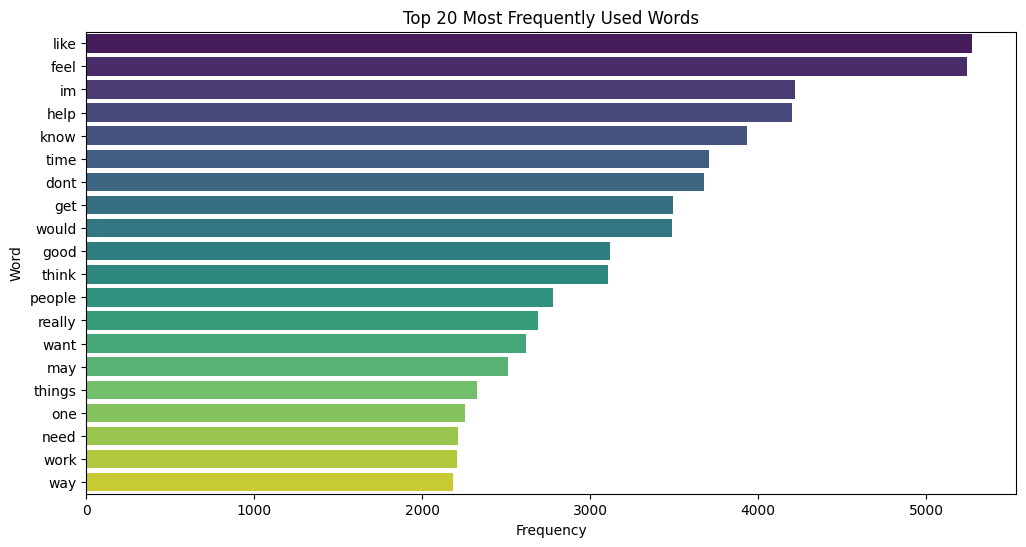

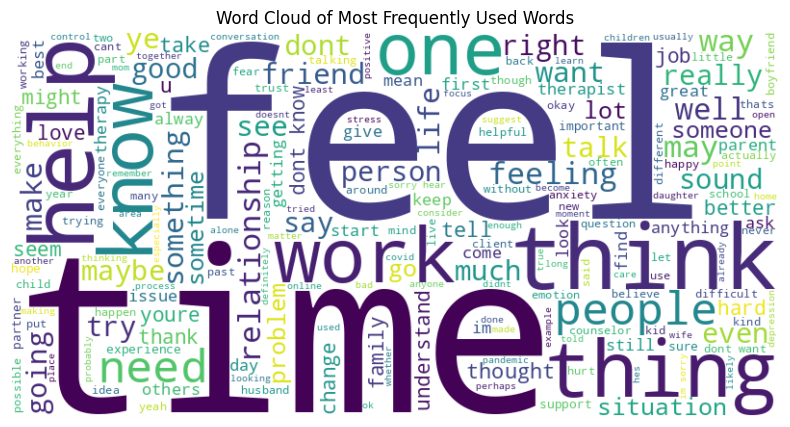

In [ ]:
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

stop_words = set(stopwords.words('english'))

all_text = ' '.join([' '.join([msg["value"] for msg in convo]) for convo in transformed_merged['conversations']])
preprocessed_text = preprocess_text(all_text)

word_counts = Counter(preprocessed_text.split())
common_words = word_counts.most_common(20)
common_words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=common_words_df, palette='viridis')
plt.title('Top 20 Most Frequently Used Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(preprocessed_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequently Used Words')
plt.show()


In [ ]:
%%capture
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048
dtype = None
load_in_4bit = True

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Phi-3-mini-4k-instruct-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth: Fast Mistral patching release 2024.5
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
from google.colab import userdata
token = userdata.get('HUGGING_FACE_HUB_TOKEN'),

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 8,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

In [ ]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "phi-3",
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"},
)

FastLanguageModel.for_inference(model)

messages = [
    {"from": "human", "value": "I'm feeling anxious with my habit of procrastination, I don't know what to do"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True,
    return_tensors = "pt",
).to("cuda")

outputs = model.generate(input_ids = inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

["<s><|user|> I'm feeling anxious with my habit of procrastination, I don't know what to do<|end|><|assistant|> It's completely normal to feel anxious about procrastination, and you're not alone in this. Here are some steps you can take to overcome this habit:\n\n1. Identify the root cause: Understand why you procrastinate. Is it due to fear of failure, perfection"]

In [ ]:
from unsloth.chat_templates import get_chat_template

EOS_TOKEN = tokenizer.eos_token
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "phi-3",
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"},
)

def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) + EOS_TOKEN for convo in convos]
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset_train = load_dataset("json", data_files = "formatted_train_data.jsonl", split="train")
dataset_test = load_dataset("json", data_files = "formatted_test_data.jsonl")

dataset_train = dataset_train.map(formatting_prompts_func, batched = True,)
dataset_test = dataset_test.map(formatting_prompts_func, batched = True,)


Map:   0%|          | 0/3160 [00:00<?, ? examples/s]

Map:   0%|          | 0/352 [00:00<?, ? examples/s]

In [ ]:
dataset_train[5]["conversations"]

[{'from': 'human',
  'value': 'I have a fear of something and I want to face that fear to overcome it, but I do not know how. What can I do?'},
 {'from': 'gpt',
  'value': 'Fear is a part of life. In fact, our five main emotions are joy, fear, sadness, shame, and anger. We tend to spend a lot of time and energy running away from or trying to get rid of most of those emotions and the more we do that, the more we set ourselves up for failure and disappointment. As a result of viewing our human emotions as "bad" or "wrong," we often get caught up in a trap of thinking we have to overcome them or get rid of them before we can do what matters to us. In reality, you can do what is important to you while having your fears! My question for you is, what would you do if this fear was completely gone? What behaviors would you have if you were the ideal you? What skills, knowledge, or personal qualities would you develop? What kind of relationships would you have?I imagine your fear has kept you f

In [ ]:
print(dataset_train[5]["text"])

<s><|user|>
I have a fear of something and I want to face that fear to overcome it, but I do not know how. What can I do?<|end|>
<|assistant|>
Fear is a part of life. In fact, our five main emotions are joy, fear, sadness, shame, and anger. We tend to spend a lot of time and energy running away from or trying to get rid of most of those emotions and the more we do that, the more we set ourselves up for failure and disappointment. As a result of viewing our human emotions as "bad" or "wrong," we often get caught up in a trap of thinking we have to overcome them or get rid of them before we can do what matters to us. In reality, you can do what is important to you while having your fears! My question for you is, what would you do if this fear was completely gone? What behaviors would you have if you were the ideal you? What skills, knowledge, or personal qualities would you develop? What kind of relationships would you have?I imagine your fear has kept you from achieving those goals beca

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset_train,
    eval_dataset = dataset_test,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 2,
        # max_steps = 10,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=2):   0%|          | 0/3160 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/352 [00:00<?, ? examples/s]

In [ ]:
print (f"GPU supports {'brain' if torch.cuda.is_bf16_supported() else 'half-precision'} floating-point.")

GPU supports half-precision floating-point.


In [ ]:
# Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
9.135 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

Step,Training Loss
1,3.225100
2,3.145200
3,2.719500
4,2.836900
5,2.598200
6,2.493300
7,2.440500
8,2.394800
9,2.452400
10,2.240000


<ipython-input-58-702649df1e10>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['smoothed_loss'] = df_train['loss'].rolling(window=window).mean()


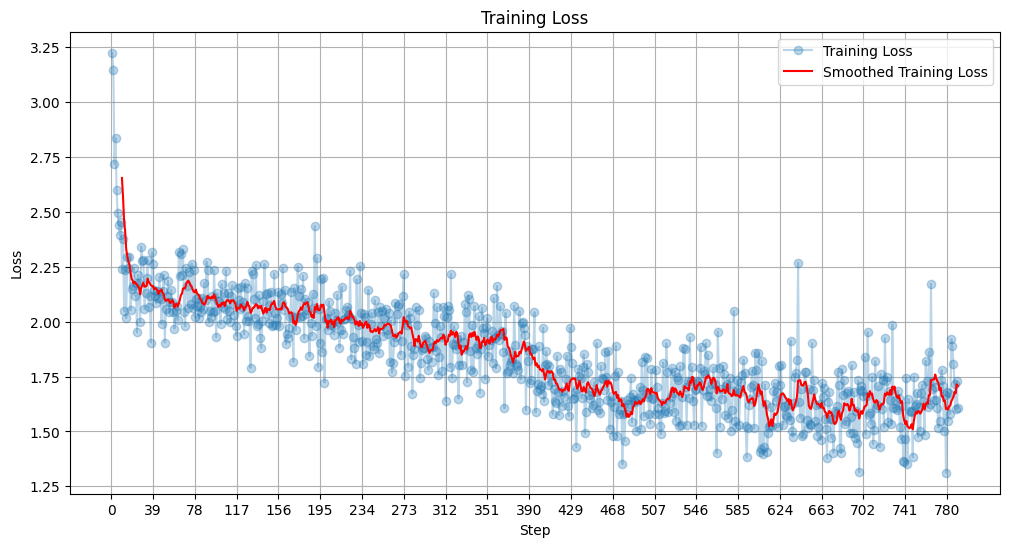

In [ ]:
import matplotlib.pyplot as plt

def plot_train_loss(log_history, window=10):
    df = pd.DataFrame(log_history)

    df['step'] = df['step'].astype(int)

    df_train = df[df['loss'].notna()]

    df_train['smoothed_loss'] = df_train['loss'].rolling(window=window).mean()

    plt.figure(figsize=(12, 6))
    plt.plot(df_train['step'], df_train['loss'], label='Training Loss', marker='o', alpha=0.3)
    plt.plot(df_train['step'], df_train['smoothed_loss'], label='Smoothed Training Loss', color='red')

    plt.xticks(range(0, df_train['step'].max() + 1, max(1, df_train['step'].max() // 20))) # Adjust interval as needed

    plt.title('Training Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_train_loss(trainer.state.log_history, window=10)

In [ ]:
trainer_eval_stats = trainer.evaluate()

OutOfMemoryError: CUDA out of memory. Tried to allocate 62.00 MiB. GPU 

In [ ]:
def plot_eval_loss(log_history, window=3):
    df = pd.DataFrame(log_history)

    df['step'] = df['step'].astype(int)

    df_eval = df[df['eval_loss'].notna()]

    df_eval['smoothed_eval_loss'] = df_eval['eval_loss'].rolling(window=window).mean()

    plt.figure(figsize=(12, 6))
    plt.plot(df_eval['step'], df_eval['eval_loss'], label='Evaluation Loss', marker='o', alpha=0.3)
    plt.plot(df_eval['step'], df_eval['smoothed_eval_loss'], label='Smoothed Evaluation Loss', color='red')

    plt.xticks(range(0, df_eval['step'].max() + 1, max(1, df_eval['step'].max() // 10)))

    plt.title('Evaluation Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the evaluation loss with smoothing
plot_eval_loss(trainer.state.log_history, window=3)


In [ ]:
# Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

4811.9248 seconds used for training.
80.2 minutes used for training.
Peak reserved memory = 13.066 GB.
Peak reserved memory for training = 3.931 GB.
Peak reserved memory % of max memory = 88.595 %.
Peak reserved memory for training % of max memory = 26.654 %.


In [ ]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "phi-3",
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"},
)

FastLanguageModel.for_inference(model)

messages = [
    {"from": "human", "value": "I'm feeling anxious with my habit of procrastination, I don't know what to do"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True,
    return_tensors = "pt",
).to("cuda")

outputs = model.generate(input_ids = inputs, max_new_tokens = 200, use_cache = True)
tokenizer.batch_decode(outputs)

["<s><|user|> I'm feeling anxious with my habit of procrastination, I don't know what to do<|end|><|assistant|> I'm glad you are aware of your procrastination. \xa0This is the first step in changing your behavior. \xa0I would suggest that you write down your goals and the steps you need to take to reach them. \xa0Then, set a time limit for each step. \xa0If you are having trouble with a step, then you can ask for help. \xa0Also, you can reward yourself for each step you complete. \xa0This will help you to stay motivated. \xa0I hope this helps. \xa0Good luck!<|end|>"]

In [ ]:
import re
from unsloth.chat_templates import get_chat_template

def clean_text(text):
    cleaned_text = re.sub(r'<[^>]+>', '', text)
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s.,!?]', '', cleaned_text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    return cleaned_text.strip()

def extract_answer(text):
    # Return the cleaned result
    return clean_text(parts[1].strip()) if len(parts) == 2 else clean_text(text.strip())

tokenizer = get_chat_template(
    tokenizer,
    chat_template="phi-3",
    mapping={"role": "from", "content": "value", "user": "human", "assistant": "gpt"}
)

FastLanguageModel.for_inference(model)

messages = [
    {"from": "human", "value": "I'm feeling anxious with my habit of procrastination, I don't know what to do"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_tensors="pt",
).to("cuda")

outputs = model.generate(input_ids=inputs, max_new_tokens=200, use_cache=True)
decoded_output = tokenizer.batch_decode(outputs)

cleaned_answer = extract_answer(decoded_output[0])
print(cleaned_answer)

Im feeling anxious with my habit of procrastination, I dont know what to do Im glad you are aware of your procrastination. This is the first step in changing your behavior. I would suggest that you write down your goals and the steps you need to take to reach them. Then, set a time limit for each step. If you are having trouble with a step, then you can ask for help. Also, you can reward yourself for each step you complete. This will help you to stay motivated. I hope this helps. Good luck!


In [ ]:
if True:
    local_model_name = "phi-3-mini-4k-emotional-support-lora"
    model.save_pretrained(local_model_name)
    tokenizer.save_pretrained(local_model_name)

In [ ]:
if True:
    from google.colab import userdata
    repo = "phi-3-mini-4k-emotional-support-lora"
    model.push_to_hub(repo, token=userdata.get('HUGGING_FACE_HUB_TOKEN'))
    tokenizer.push_to_hub(repo, token=userdata.get('HUGGING_FACE_HUB_TOKEN'))

config.json:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

Saved model to https://huggingface.co/phi-3-mini-4k-emotional-support-lora


In [ ]:
# Save to 16-bit GGUF
model_name = "phi-3-mini-4k-emotional-support-f16-gguf"
if True: model.push_to_hub_gguf(model_name, tokenizer, quantization_method = "f16", token = userdata.get('HUGGING_FACE_HUB_TOKEN'))


Unsloth: You have 1 CPUs. Using `safe_serialization` is 10x slower.
We shall switch to Pytorch saving, which will take 3 minutes and not 30 minutes.
To force `safe_serialization`, set it to `None` instead.
Unsloth: Kaggle/Colab has limited disk space. We need to delete the downloaded
model which will save 4-16GB of disk space, allowing you to save on Kaggle/Colab.
Unsloth: Will remove a cached repo with size 2.3G


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 4.22 out of 12.67 RAM for saving.


100%|██████████| 32/32 [00:14<00:00,  2.22it/s]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving model... This might take 5 minutes for Llama-7b...
Unsloth: Saving phi-3-mini-4k-emotional-support-f16-gguf/pytorch_model-00001-of-00002.bin...
Unsloth: Saving phi-3-mini-4k-emotional-support-f16-gguf/pytorch_model-00002-of-00002.bin...
Done.


Unsloth: ##### The current model type of mistral auto adds a BOS token.
Unsloth: ##### If you're using Ollama or GGUF etc, do not add a BOS in the chat template.
Unsloth: Converting mistral model. Can use fast conversion = True.


==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp will take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GUUF 16bits will take 3 minutes.
\        /    [2] Converting GGUF 16bits to f16 will take 20 minutes.
 "-____-"     In total, you will have to wait around 26 minutes.

Unsloth: [0] Installing llama.cpp. This will take 3 minutes...


Unsloth: Extending phi-3-mini-4k-emotional-support-f16-gguf/tokenizer.model with added_tokens.json.
Originally tokenizer.model is of size (32000).
But we need to extend to sentencepiece vocab size (32011).


Unsloth: [1] Converting model at phi-3-mini-4k-emotional-support-f16-gguf into f16 GGUF format.
The output location will be ./phi-3-mini-4k-emotional-support-f16-gguf-unsloth.F16.gguf
This will take 3 minutes...
INFO:hf-to-gguf:Loading model: phi-3-mini-4k-emotional-support-f16-gguf
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Set model parameters
INFO:hf-to-gguf:gguf: context length = 4096
INFO:hf-to-gguf:gguf: embedding length = 3072
INFO:hf-to-gguf:gguf: feed forward length = 8192
INFO:hf-to-gguf:gguf: head count = 32
INFO:hf-to-gguf:gguf: key-value head count = 32
INFO:hf-to-gguf:gguf: rope theta = 10000.0
INFO:hf-to-gguf:gguf: rms norm epsilon = 1e-05
INFO:hf-to-gguf:gguf: file type = 1
INFO:hf-to-gguf:Set model tokenizer
INFO:gguf.vocab:Setting special token type bos to 1
INFO:gguf.vocab:Setting special token type eos to 32000
INFO:gguf.vocab:Setting special token type unk to 0
INFO:gguf.vocab:Setting special token type pad to 32009
INFO:gg

phi-3-mini-4k-emotional-support-f16-gguf-unsloth.F16.gguf:   0%|          | 0.00/7.64G [00:00<?, ?B/s]

Unsloth: ##### The current model type of mistral auto adds a BOS token.
Unsloth: ##### If you're using Ollama or GGUF etc, do not add a BOS in the chat template.


Saved GGUF to https://huggingface.co/arg0x/phi-3-mini-4k-emotional-support-f16-gguf


In [ ]:
# Save to q4_k_m GGUF
model_name = "phi-3-mini-4k-emotional-support-gguf"
if True: model.push_to_hub_gguf(model_name, tokenizer, quantization_method = "q4_k_m", token = userdata.get('HUGGING_FACE_HUB_TOKEN'))


Unsloth: Will remove a cached repo with size 1.2K


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 5.27 out of 12.67 RAM for saving.


100%|██████████| 32/32 [00:01<00:00, 29.22it/s]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving model... This might take 5 minutes for Llama-7b...
Unsloth: Saving arg0x/phi-3-mini-4k-emotional-support-gguf/pytorch_model-00001-of-00002.bin...
Unsloth: Saving arg0x/phi-3-mini-4k-emotional-support-gguf/pytorch_model-00002-of-00002.bin...
Done.


Unsloth: ##### The current model type of mistral auto adds a BOS token.
Unsloth: ##### If you're using Ollama or GGUF etc, do not add a BOS in the chat template.
Unsloth: Extending arg0x/phi-3-mini-4k-emotional-support-gguf/tokenizer.model with added_tokens.json.
Originally tokenizer.model is of size (32000).
But we need to extend to sentencepiece vocab size (32011).


==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp will take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GUUF 16bits will take 3 minutes.
\        /    [2] Converting GGUF 16bits to q4_k_m will take 20 minutes.
 "-____-"     In total, you will have to wait around 26 minutes.

Unsloth: [0] Installing llama.cpp. This will take 3 minutes...
Unsloth: [1] Converting model at arg0x/phi-3-mini-4k-emotional-support-gguf into f16 GGUF format.
The output location will be ./arg0x/phi-3-mini-4k-emotional-support-gguf-unsloth.F16.gguf
This will take 3 minutes...
INFO:hf-to-gguf:Loading model: phi-3-mini-4k-emotional-support-gguf
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Set model parameters
INFO:hf-to-gguf:gguf: context length = 4096
INFO:hf-to-gguf:gguf: embedding length = 3072
INFO:hf-to-gguf:gguf: feed forward length = 8192
INFO:hf-to-gguf:gguf: head count = 32
INFO:hf-to-gguf:gguf: key-value head c

In [ ]:
# Merge to 4-bit
model_name = "phi-3-mini-4k-emotional-support-4bit-vllm"
if True: model.push_to_hub_merged(model_name, tokenizer, save_method = "merged_4bit", token = userdata.get('HUGGING_FACE_HUB_TOKEN'))


RuntimeError: Unsloth: Merging into 4bit will cause your model to lose accuracy if you plan
to merge to GGUF or others later on. I suggest you to do this as a final step
if you're planning to do multiple saves.
If you are certain, change `save_method` to `merged_4bit_forced`.

In [ ]:
model_name = "phi-3-mini-4k-emotional-support-4bit-vllm"
# Merge to 4-bit
if True: model.push_to_hub_merged(model_name, tokenizer, save_method = "merged_4bit_forced", token = userdata.get('HUGGING_FACE_HUB_TOKEN'))


Unsloth: Merging 4bit and LoRA weights to 4bit...
This might take 5 minutes...


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/bnb.py:325: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


Done.
Unsloth: Saving 4bit Bitsandbytes model. Please wait...


README.md:   0%|          | 0.00/600 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.26G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/606 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

Saved merged_4bit model to https://huggingface.co/arg0x/phi-3-mini-4k-emotional-support-4bit-vllm
